# Introduction
This tutorial uses simulated data with one continuous predictor variable (`birthyear`) and a binary outcome variable (`is_happy`). It demonstrates why ordinary least-squares (OLS) regression is a bad choice for modeling such data, and shows how to model it using logistic regression instead (via the `glm` function). All code examples use [the R language](http://cran.r-project.org/).

If you want to step through this tutorial using your own data, you will need to change a few of the variable names: change `mydata` to the name of your data frame, `is_happy` to the name of your binary outcome variable, and `birthyear` to the name of your continuous predictor variable. A few other variables get created along the way (e.g., `centered_birthyear`) that you may want to change as well. Also note that your continuous predictor may not be measured in years like `birthyear` is, so when thinking about the interpretation of the slope you will need to translate "year" to "one-unit change in the continuous predictor".

# Loading the data
First, we'll read in the data. While we’re at it, we’ll define some colors that are a little nicer than the R default colors, and are easier to discriminate by people with colorblindness.

In [1]:
mydata <- read.delim("happiness-data.tsv")
# colorblindness-friendly colors
red <- "#CC6677"
blue <- "#4477AA"
gold <- "#DDCC77"

Here is the raw data plotted as blue circles, with a bit of vertical jitter added for better visibility of individual data points:

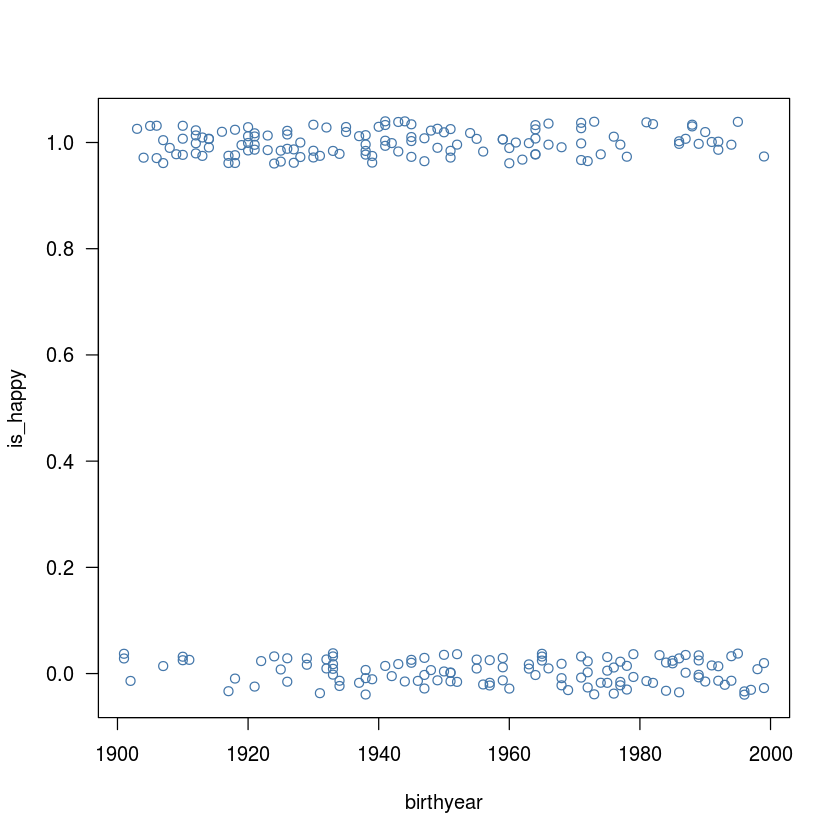

In [2]:
mydata$jittered <- jitter(mydata$is_happy, amount=0.04)
with(mydata, plot(jittered~birthyear, ylab="is_happy", col=blue, las=1))

# Ordinary least-squares (OLS) regression
A normal linear model uses Equation (@ols), and chooses values for intercept and slope that minimize the vertical distance from the prediction line to the data points.

$\textrm{is_happy} = \textrm{intercept} + \textrm{slope} \times \textrm{birthyear}$

Here we plot the result of OLS regression on our happiness data, with a thick red line showing the model's best fit to the data.

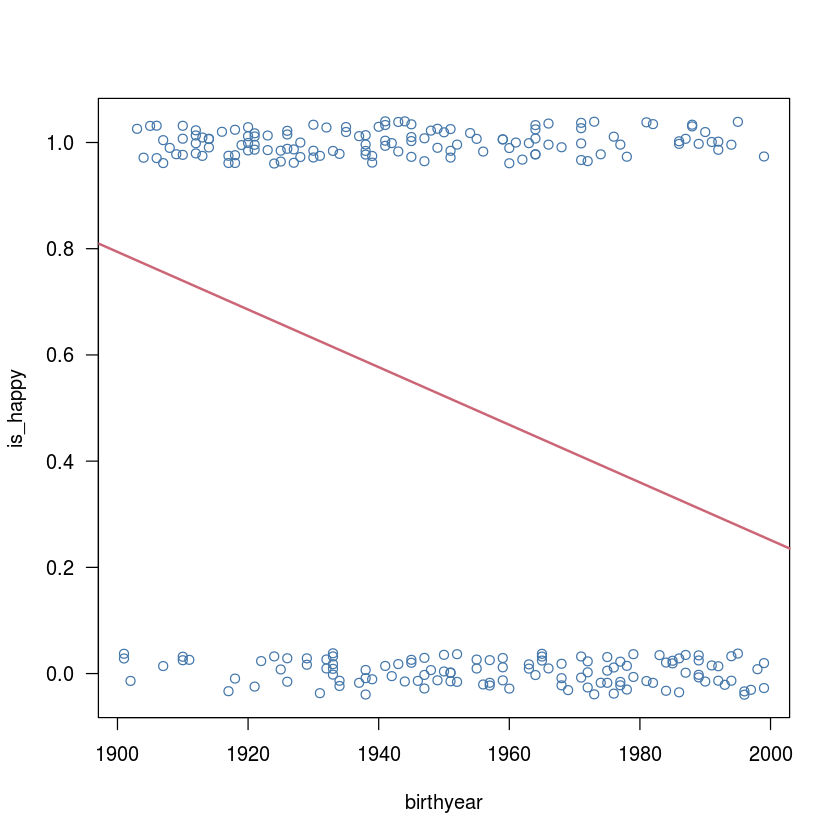

In [3]:
OLS_model <- with(mydata, lm(is_happy~birthyear))
with(mydata, plot(jittered~birthyear, ylab="is_happy", col=blue, las=1))
abline(OLS_model$coefficients, col=red, lwd=2)

There are at least two problems with this approach. First, the prediction line takes on values in between 0 and 1, and (for dates earlier than 1900 or later than 2000) can even take on values that are below 0 or above 1. Such values are not meaningful when the outcome variable is understood as a true/false value. 

Another problem with using OLS regression for binary outcomes is that OLS regression models have some built-in assumptions about the data that are not met by the data we are using. Specifically, OLS regression assumes that the residuals (the vertical distances between the “best-fit” line and the data points) are normally distributed with a mean of 0. This is almost never the case when the outcome variable is binary. Here are plots of the residuals shown in two different ways: as thin vertical line segments from the prediction line to the actual data values, and as a histogram of the lengths of those lines. The histogram also shows a normal curve indicating roughly how the histogram _should_ look if that assumption of OLS regression were met.

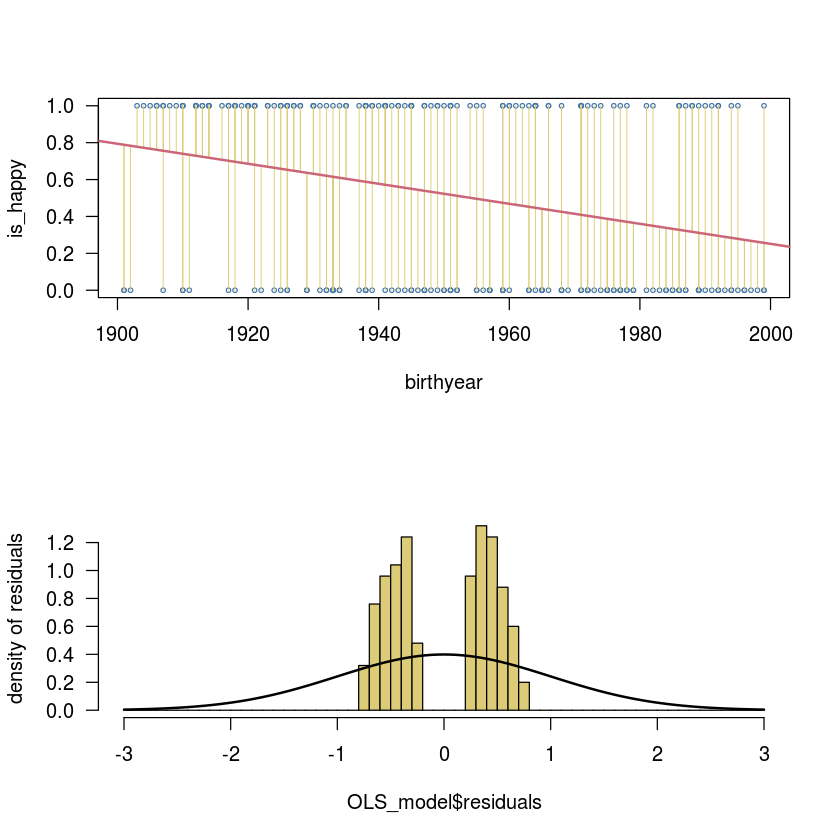

In [4]:
par(mfrow=c(2, 1))

# plot 1: residuals as segments connecting prediction line & data
with(mydata, plot(is_happy~birthyear, ylab="is_happy", col=blue, las=1,
                  cex=0.5))
with(mydata, segments(x0=birthyear, y0=is_happy, y1=OLS_model$fitted.values,
                      col=gold, lwd=0.75))
abline(OLS_model$coefficients, col=red, lwd=2)

# plot 2: histogram of residuals with normal curve showing model assumption
hist(OLS_model$residuals, breaks=seq(-3, 3, 0.1), freq=FALSE, col=gold,
     xlim=c(-3, 3), las=1, ylab="density of residuals", main="")
curve(dnorm, -3, 3, lwd=2, add=TRUE)

# Logistic regression
Instead of fitting a line to the raw 1s and 0s of the data, logistic regression models the _probability_ that the outcome is 1 given the value of the predictor. Since probabilities have to be between 0 and 1, to do this we need a function that transforms our predictor variable (which in theory could range from −∞ to +∞) to a value between 0 and 1. Lots of functions can do that, but the logistic function is the most appropriate choice when dealing with probabilities.

$$\textrm{theLogisticFunction}\thinspace(t) = \frac{1}{1 + e^{-t}}$$

In R, we implement this as `1 / (1 + exp(-t))` where `t` is our continuous predictor variable. We can apply the logistic function to transform the right side of the OLS regression equation, and use it to model the _probability_ of happiness instead of the raw `is_happy` value, as seen here:

$$P(\textrm{is_happy}) = \textrm{theLogisticFunction}(\textrm{intercept} + \textrm{slope} \times \textrm{birthyear})$$

In practice, the transformation is actually achieved by applying the “inverse logistic function” (aka, the “logit” function: $\textrm{logit}(p) = log(\frac{p}{1-p})$) to the left side of the equation (instead of applying the logistic function to the right side):

$$\textrm{logit}(P(\textrm{is_happy})) = \textrm{intercept} + \textrm{slope} \times \textrm{birthyear}$$

## Probability, odds, and log-odds
The left-hand side of the above equation, with the form $\textrm{logit}(P(\textrm{some_binary_outcome}))$ is also known as the “log-odds”. In gambling contexts, odds are usually given as “five-to-four in favor”; in statistics the meaning of odds is the same (expected number of “yes” results divided by expected number of “no” results), but the odds are reduced to a single number ($\textrm{“5-to-4”} = \frac{5}{4} = 1.25$) and “log-odds” is just $log(\textrm{odds})$. We can easily convert back and forth among log-odds, odds, and probability:

$$\begin{alignat}{3}
\textrm{odds} & = e^{\textrm{log odds}} && = \frac{\textrm{probability}}{1 - \textrm{probability}} \\
\textrm{log odds} & = log(\textrm{odds}) && = log(\frac{\textrm{probability}}{1 - \textrm{probability}}) \\
\textrm{probability} & = \frac{\textrm{odds}}{1 + \textrm{odds}} && = \frac{e^{\textrm{log odds}}}{1 + e^{\textrm{log odds}}}
\end{alignat}$$

## Specifying a logistic regression model
To specify a logistic regression model we use the `glm` function. Of course, because the logistic regression equation is different from the OLS regression equation, it is going to estimate different coefficients than the ordinary least-squares model:

In [5]:
logit_model <- with(mydata, glm(is_happy~birthyear, family=binomial(link=logit)))
cbind(logit=logit_model$coefficients, OLS=OLS_model$coefficients)

,logit,OLS
(Intercept),44.94598786,11.103189367
birthyear,-0.02299902,-0.005425919


The intercept in the logistic regression model should seem unusually large. Remember that the left-hand-side of our model equation is $\textrm{logit}(P(\textrm{is_happy}))$, or equivalently, the log-odds of being happy. Log-odds of `44.95` translates to odds of `3.3 × 10¹⁹`, or a probability of `0.999...`, meaning virtually _everyone_ was happy... **in the year 0.** This shows that interpreting the intercept is a bit tricky, and depending on the range of your continuous predictor, not always very meaningful or useful. 

For this reason it is often helpful to transform the predictor values into a more managable range before running the statistical model. The most common approach is “centering” and/or “scaling”, which subtracts the mean from each predictor value (centering the values around 0) and/or divides them by their root mean square value. The function `scale` does both centering and scaling by default, but right now let’s just do the centering step. That way, a one-unit change of our predictor still equals 1 year, which will make it easier to interpret the slope coefficient.

In [6]:
mydata$centered_birthyear <- scale(mydata$birthyear, scale=FALSE, center=TRUE)
logit_model_centered <- with(mydata, glm(is_happy~centered_birthyear,
                                         family=binomial(link=logit)))
logit_model_centered$coefficients

(Intercept) centered_birthyear 
        0.08667408        -0.02299902

Now the intercept looks more reasonable: a log-odds of `0.87`, which translates to odds of `1.09` and a probability of `0.52`. This intercept is still the log-odds of being happy at “zero”, but now zero is the _mean_ of our birthyear values (in this case, the year `1950.49`, or roughly the halfway point of our data) instead of a date 1900 years before the start of our data range.

Before moving on, let’s extract the center, intercept and slope for easier reuse. Then, using the logit equation and the methods for converting between log-odds, odds and probabilities seen above, we can easily obtain the modeled probability:

In [7]:
# extract coefficients
center <- attr(mydata$centered_birthyear, "scaled:center")
intercept <- as.vector(logit_model_centered$coefficients["(Intercept)"])
slope <- as.vector(logit_model_centered$coefficients["centered_birthyear"])

# predicted outcome values for each data point in "birthyear":
mydata$log_odds <- intercept + slope * mydata$centered_birthyear
mydata$odds <- exp(mydata$log_odds)
mydata$prob <- mydata$odds / (1 + mydata$odds)

## Plotting the model predictions
At this point we can plot the modeled probability as a function of the predictor. We'll plot predicted values from the model with gold circles. A thin blue line connecting the endpoints of the predicted data is also shown; this makes it easier to see that the predicted points are **not** in fact perfectly linear. Remember, it is _log-odds_, not probability, that is assumed to be linearly related to our predictor variables, so we shouldn't expect our predicted probabilities to necessarily fall on a straight line.

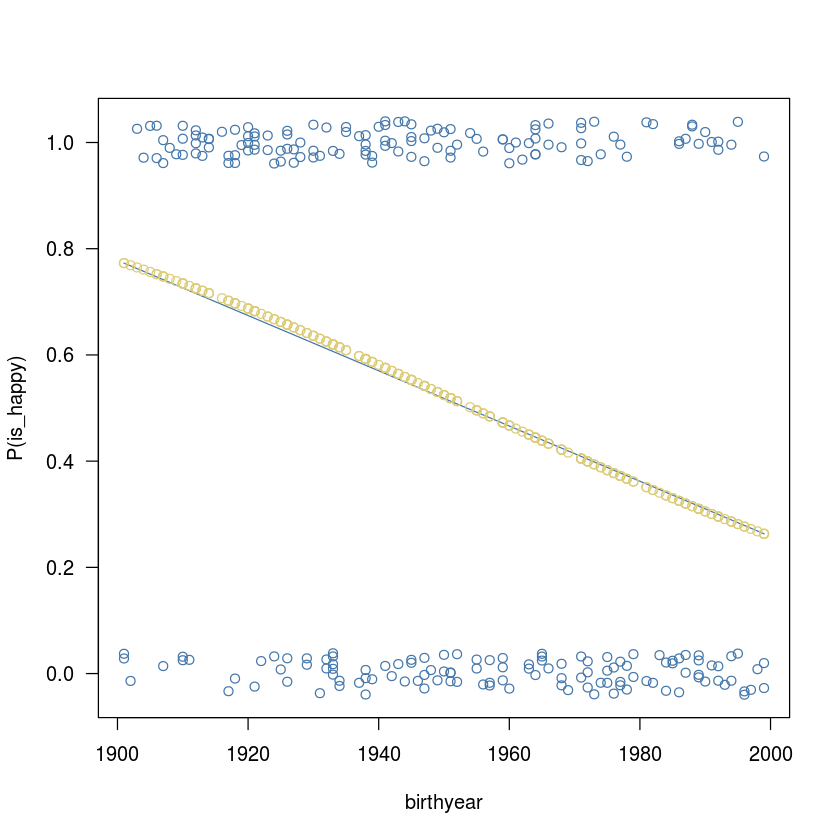

In [8]:
endpoints <- c(1, nrow(mydata))
with(mydata, {
    plot(jittered~birthyear, ylab="P(is_happy)", col=blue, las=1)
    points(birthyear[endpoints], prob[endpoints], type="l", col=blue)
    points(prob~birthyear, col=gold)
})

If we want to add a confidence interval around the plotted predictions, we can use the `predict` function with `se.fit=TRUE` to get confidence intervals around each predicted value. We'll define a new color first so we can make the confidence band semi-transparent. If you just want confidence intervals for the model parameters (intercept & slope), you can get those via `confint(logit_model_centered)`.

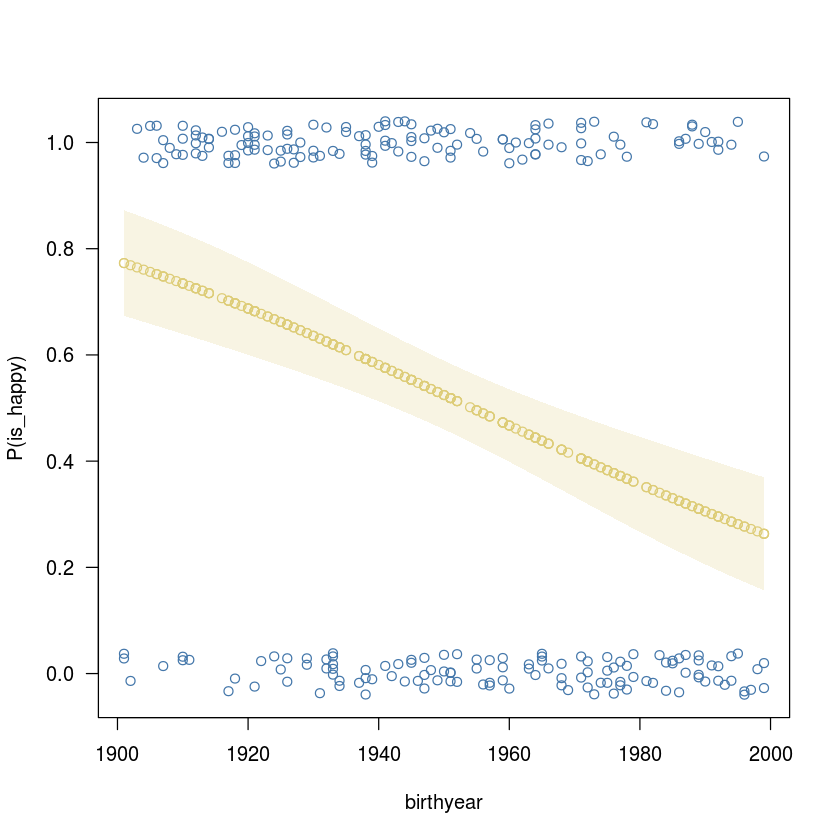

In [9]:
transp_gold <- do.call(rgb, as.list(rbind(col2rgb(gold)/255, alpha=0.2)))
predictions <- predict(logit_model_centered, type="response", se.fit=TRUE)
lower <- with(predictions, fit + qnorm(0.025) * se.fit)
upper <- with(predictions, fit + qnorm(0.975) * se.fit)
with(mydata, {
    plot(jittered~birthyear, ylab="P(is_happy)", col=blue, las=1)
    polygon(c(birthyear, rev(birthyear)), c(lower, rev(upper)), border=NA, col=transp_gold)
    points(predictions$fit~birthyear, col=gold)
})

## Evaluating the model
Model statistics are available with the `summary` function:

In [10]:
summary(logit_model_centered)


Call:
glm(formula = is_happy ~ centered_birthyear, family = binomial(link = logit))

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.7219  -1.0909   0.7586   1.0510   1.6338  

Coefficients:
                    Estimate Std. Error z value Pr(>|z|)    
(Intercept)         0.086674   0.132368   0.655    0.513    
centered_birthyear -0.022999   0.005137  -4.478 7.55e-06 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 346.17  on 249  degrees of freedom
Residual deviance: 324.35  on 248  degrees of freedom
AIC: 328.35

Number of Fisher Scoring iterations: 4


In the `Coefficients` table, the coefficient for `centered_birthyear` (i.e., the slope coefficient) indicates that the log-odds of being happy decreases by about `0.023` per year in our data. The model summary indicates that this slope is statistically significantly different from zero (the `Pr(<|z|)` column gives *p*-values in this type of model), suggesting that the apparent decline in happiness is not due to chance alone.

Because the slope is a _difference_ in log-odds of happiness corresponding to a 1-year change in birthyear, converting into odds yields a multiplicative slope (i.e., the amount you would _multiply_ the odds of happiness in year `t` to get the odds of happiness in the year `t+1`). This quantity is called the _odds ratio_. The change from additive (slope on a log-odds scale) to multiplicative (slope on an odds scale) is a consequence of the basic property of logarithms $log(a) - log(b) = log(\frac{a}{b})$, combined with the use of exponentiation when converting between log-odds and odds (i.e., the fact that we convert from log-odds to odds via the `exp()` function). Applying that basic property of logarithms to the slope we get:

$$\textrm{slope} = \frac{\textrm{change in }y}{\textrm{change in }x} = \frac{log(\textrm{odds}\thinspace_{t+1}) - log(\textrm{odds}\thinspace_t)}{1 \textrm{ year}} = log(\frac{\textrm{odds}\thinspace_{t+1}}{\textrm{odds}\thinspace_t})$$

Converting the slope from a log-odds scale to an odds scale we get:

$$\textrm{odds ratio} = e^{\textrm{slope}} = e^{log(\textrm{odds}\thinspace_{t+1}) - log(\textrm{odds}\thinspace_t)} = e^{log(\frac{\textrm{odds}\thinspace_{t+1}}{\textrm{odds}\thinspace_t})} = \frac{\textrm{odds}\thinspace_{t+1}}{\textrm{odds}\thinspace_t}$$

In our case, the odds ratio (obtained via `exp(slope)` in R) is `0.977`, so if we know the odds of being happy in a given year, we can multiply by `0.977` to get the odds of being happy one year later. Unfortunately, the odds ratio cannot easily be converted into anything like a slope for _probability_. As mentioned above, there is no assumption that probability will be linearly related to the predictor variables, so there is no guarantee that there will be an invariant slope across the range of our data. We can get predicted probabilities for each data point (as shown above), or for any specific value of the predictor even if it's not present in our original data:

In [11]:
odds_2010 <- exp(intercept + slope * (2010 - center))
probability_2010 <- odds_2010 / (1 + odds_2010)

...but the change in probability between years is not guaranteed to be constant, so the slope between different pairs of data points is likewise not guaranteed to be constant. To reiterate, it is _log-odds_, not probability, that is assumed to be linearly related to our predictor variables in logistic regression models.

# Appendix: Data simulation
The sample data for this tutorial was generated as follows. First, a continuous predictor `birthyear` is randomly chosen between 1900 and 1999. Next, we specify in advance that the probability of being happy gets lower with time, ranging linearly from probability 0.7 in 1900 to probability 0.3 in 1999. That information is used to decide whether our binary outcome `is_happy` is `TRUE` or `FALSE` for each `birthyear` data point.

In [12]:
set.seed(0)  # makes the randomness reproducible across sessions
num_data_pts <- 250
birthyear <- sort(sample(seq(1900, 1999), num_data_pts, replace=TRUE))
true_prob <- 0.7 - 0.4 * (birthyear - 1900) / 100
is_happy <- rbinom(num_data_pts, 1, true_prob)
write.table(cbind(birthyear, is_happy), "happiness-data.tsv", row.names=FALSE,
            sep="\t", eol="\n")

Because we simulated this data, we can compare `true_prob` to the probabilities estimated by our statistical model, to see how close the model got to the truth (normally we don't know `true_prob` so this isn't possible).

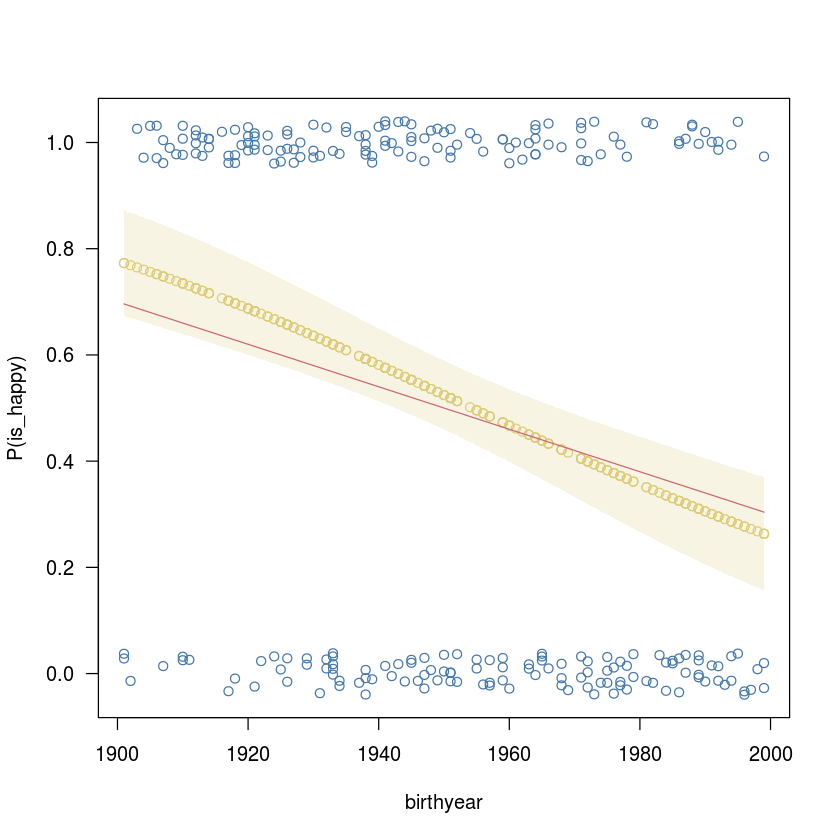

In [13]:
with(mydata, {
    plot(jittered~birthyear, ylab="P(is_happy)", col=blue, las=1)
    polygon(c(birthyear, rev(birthyear)), c(lower, rev(upper)), border=NA, col=transp_gold)  # confidence interval
    points(predictions$fit~birthyear, col=gold)  # predicted probabilities
    points(true_prob~birthyear, col=red, type="l")  # true probabilities
})

# See also
[UCLA institute for digital research and education: Odds ratio](http://www.ats.ucla.edu/stat/mult_pkg/faq/general/odds_ratio.htm)

[Wikipedia: Logistic regression](http://en.wikipedia.org/wiki/Logistic_regression)